In [1]:
import warnings, os
warnings.filterwarnings("ignore")

from copy import copy
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import roc_auc_score, matthews_corrcoef, precision_score, recall_score, f1_score


import seaborn as sns
import matplotlib.pyplot as plt
from joblib import dump, load

from aggmap import AggMap, AggModel, loadmap
from aggmap.AggModel import load_model, save_model
from aggmap import show


#grey: #999999
np.random.seed(666) #just for reaptable results


In [2]:
from gen_nwk import dfs_to_weightless_newick, mp2newick

In [3]:
task = 'IBD'
data_path = '../../01_data/species_level/%s/' % (task)
save_dir = 'test_%s_results' % task
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

dfa = pd.read_csv(os.path.join(data_path, 'abundance.tsv'),sep='\t', header=None, index_col=0)
dfy = pd.read_csv(os.path.join(data_path, 'labels.txt'),sep='\t', header=None)
dfx = dfa.T
dfy = pd.get_dummies(dfy[0].map({'ibd':1, 'n':0}))
Y = dfy.values

In [4]:
#could be optimized
dfx = np.log(dfx + 1e-2)
mp = AggMap(dfx, metric = 'correlation')

2021-08-27 14:08:17,338 - INFO - [bidd-aggmap] - Calculating distance ...
2021-08-27 14:08:17,349 - INFO - [bidd-aggmap] - the number of process is 16


100%|##########| 443/443 [00:00<00:00, 847.44it/s]


In [5]:
dfs = pd.Series(dfx.columns).apply(lambda x: dict([i.split('__') for i in x.split('|')])).apply(pd.Series)
level_dict = {'k':'kingdom', 'p':'phylum', 'c':'class' ,'o':'order' ,'f':'family' ,'g': 'genus','s': 'species'}
dfs = dfs.rename(columns=level_dict)
dfs['idx'] = dfx.columns
dfs

,kingdom,phylum,class,order,family,genus,species,idx
0,Archaea,Euryarchaeota,Methanobacteria,Methanobacteriales,Methanobacteriaceae,Methanobrevibacter,Methanobrevibacter_smithii,k__Archaea|p__Euryarchaeota|c__Methanobacteria...
1,Archaea,Euryarchaeota,Methanobacteria,Methanobacteriales,Methanobacteriaceae,Methanobrevibacter,Methanobrevibacter_unclassified,k__Archaea|p__Euryarchaeota|c__Methanobacteria...
2,Archaea,Euryarchaeota,Methanobacteria,Methanobacteriales,Methanobacteriaceae,Methanosphaera,Methanosphaera_stadtmanae,k__Archaea|p__Euryarchaeota|c__Methanobacteria...
3,Bacteria,Acidobacteria,Acidobacteriia,Acidobacteriales,Acidobacteriaceae,Acidobacteriaceae_unclassified,NaN,k__Bacteria|p__Acidobacteria|c__Acidobacteriia...
4,Bacteria,Actinobacteria,Actinobacteria,Actinomycetales,Actinomycetaceae,Actinomyces,Actinomyces_graevenitzii,k__Bacteria|p__Actinobacteria|c__Actinobacteri...
...,...,...,...,...,...,...,...,...
438,Bacteria,Firmicutes,Bacilli,Lactobacillales,Lactobacillaceae,Pediococcus,Pediococcus_lolii,k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactob...
439,Bacteria,Firmicutes,Clostridia,Clostridiales,Clostridiales_Family_XI_Incertae_Sedis,Peptoniphilus,Peptoniphilus_sp_oral_taxon_375,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clo...
440,Bacteria,Firmicutes,Negativicutes,Selenomonadales,Acidaminococcaceae,Acidaminococcus,Acidaminococcus_sp_HPA0509,k__Bacteria|p__Firmicutes|c__Negativicutes|o__...
441,Bacteria,Proteobacteria,Epsilonproteobacteria,Campylobacterales,Helicobacteraceae,Helicobacter,Helicobacter_pullorum,k__Bacteria|p__Proteobacteria|c__Epsilonproteo...


In [6]:
nwk_string = dfs_to_weightless_newick(dfs)
with open(os.path.join(save_dir, "genotype_tree.nwk"), "w") as f:
    f.write(nwk_string)

In [7]:
merge_value = {'kingdom':0, 'phylum':2, 'class': 2, 'order':2, 'family':1, 'genus':1}
channel_info = {'grayscale': {'feature_group_list':['FP' for i in range(len(dfs))], 'channels':1}} #level-0

for level in merge_value.keys():
    so = dfs.groupby(level).size() 
    md = {}
    for i, j in so.items():
        if j <= merge_value.get(level):
            md[i] = 'Others'
        else:
            md[i] = i

    res = dfs[level].map(md)
    feature_group_list = res.tolist()
    c = len(pd.Series(feature_group_list).value_counts())
    info = {level:{'feature_group_list':feature_group_list, 'channels':c}}
    channel_info.update(info)

In [8]:
pd.Series(channel_info).apply(lambda x:x.get('channels'))

grayscale     1
kingdom       3
phylum       10
class        18
order        23
family       49
genus        68
dtype: int64

In [9]:
c = 3

2021-08-27 14:25:14,624 - INFO - [bidd-aggmap] - applying hierarchical clustering to obtain group information ...
2021-08-27 14:25:15,530 - INFO - [bidd-aggmap] - Applying grid feature map(assignment), this may take several minutes(1~30 min)
2021-08-27 14:25:15,730 - INFO - [bidd-aggmap] - Finished


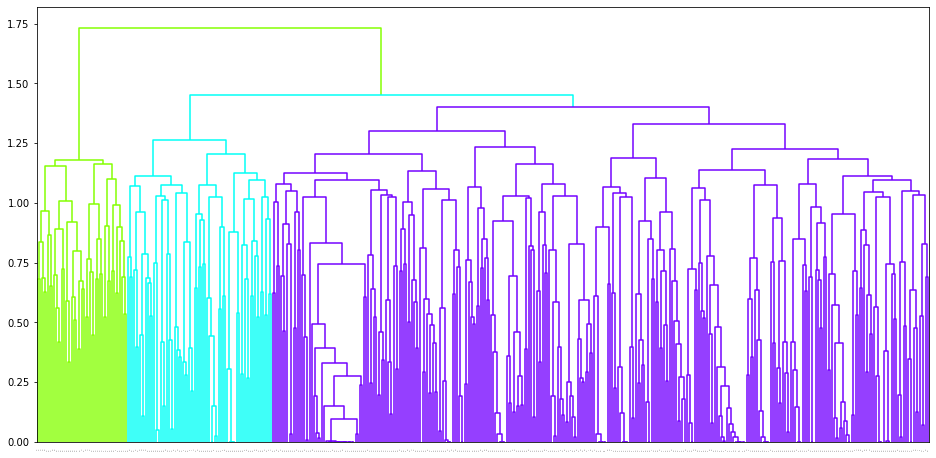

In [24]:
mp3 = mp.fit(cluster_channels = 3, verbose = 0,)
fig_tree = mp3.plot_tree(add_leaf_labels = False, leaf_font_size = 1)

In [25]:
mp3.plot_grid(htmlpath=save_dir, htmlname='phenotype-mp3')

2021-08-27 14:25:24,933 - INFO - [bidd-aggmap] - generate file: test_IBD_results/phenotype-mp3_feature points_443_correlation_umap_mp
2021-08-27 14:25:24,950 - INFO - [bidd-aggmap] - save html file to test_IBD_results/phenotype-mp3_feature points_443_correlation_umap_mp


In [28]:
dfr = mp2newick(mp3, treefile=os.path.join(save_dir, 'C03_phenotype_tree'))

2021-08-27 14:29:08,538 - INFO - [bidd-aggmap] - applying hierarchical clustering to obtain group information ...
2021-08-27 14:29:09,449 - INFO - [bidd-aggmap] - Applying grid feature map(assignment), this may take several minutes(1~30 min)
2021-08-27 14:29:09,655 - INFO - [bidd-aggmap] - Finished


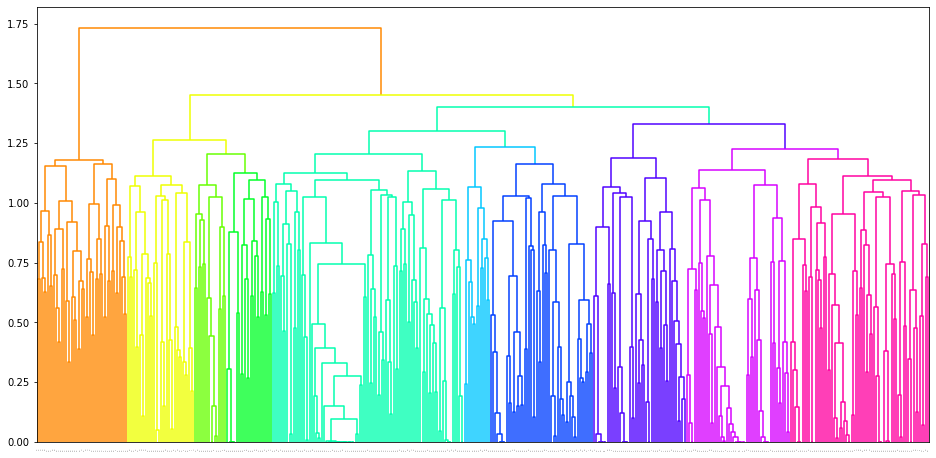

In [29]:
mp10 = mp.fit(cluster_channels = 10, verbose = 0,)
fig_tree = mp10.plot_tree(add_leaf_labels = False, leaf_font_size = 1)

In [30]:
mp10.plot_grid(htmlpath=save_dir, htmlname='phenotype-mp10')

2021-08-27 14:29:18,984 - INFO - [bidd-aggmap] - generate file: test_IBD_results/phenotype-mp10_feature points_443_correlation_umap_mp
2021-08-27 14:29:19,008 - INFO - [bidd-aggmap] - save html file to test_IBD_results/phenotype-mp10_feature points_443_correlation_umap_mp


In [31]:
dfr = mp2newick(mp10, treefile=os.path.join(save_dir, 'C10_phenotype_tree'))

In [38]:
itol_header = '''TREE_COLORS
SEPARATOR TAB

#First 3 fields define the node id, type and color
#Possible types are:
#'range': defines a colored range (colored background for labels/clade)
#'clade': defines color/style for all branches in a clade
#'branch': defines color/style for a single branch
#'label': defines font color/style for the leaf label
#'label_background': defines the leaf label background color

#The following additional fields are required:
#for 'range', field 4 defines the colored range label (used in the legend)

#The following additional fields are optional:
#for 'label', field 4 defines the font style ('normal',''bold', 'italic' or 'bold-italic') and field 5 defines the numeric scale factor for the font size (eg. with value 2, font size for that label will be 2x the standard size)
#for 'clade' and 'branch', field 4 defines the branch style ('normal' or 'dashed') and field 5 defines the branch width scale factor (eg. with value 0.5, branch width for that clade will be 0.5 the standard width)

DATA
#NODE_ID TYPE COLOR LABEL_OR_STYLE SIZE_FACTOR
'''

In [39]:
mp3 = mp.fit(feature_group_list = channel_info['kingdom']['feature_group_list'], verbose = 0,)
fig_tree = mp3.plot_tree(add_leaf_labels = False, leaf_font_size = 1)
treefile=os.path.join(save_dir, 'C03_genotype_tree')
df = mp.df_embedding[['colors','Subtypes']]
df['TYPE'] = 'clade'
df['STYLE'] = 'normal'
df = df[['TYPE', 'colors', 'STYLE']]
with open(treefile + '.txt', 'w') as f:
    f.write(itol_header)
df.to_csv(treefile + '.txt', mode = 'a', header=None, sep='\t')

2021-08-27 16:20:07,409 - INFO - [bidd-aggmap] - Applying grid feature map(assignment), this may take several minutes(1~30 min)
2021-08-27 16:20:07,609 - INFO - [bidd-aggmap] - Finished


<Figure size 1152x576 with 0 Axes>

In [40]:
mp3.plot_grid(htmlpath=save_dir, htmlname='genotype-mp3')

2021-08-27 16:20:34,005 - INFO - [bidd-aggmap] - generate file: test_IBD_results/genotype-mp3_feature points_443_correlation_umap_mp
2021-08-27 16:20:34,022 - INFO - [bidd-aggmap] - save html file to test_IBD_results/genotype-mp3_feature points_443_correlation_umap_mp


In [41]:
mp3 = mp.fit(feature_group_list = channel_info['phylum']['feature_group_list'], verbose = 0,)
fig_tree = mp3.plot_tree(add_leaf_labels = False, leaf_font_size = 1)
treefile=os.path.join(save_dir, 'C10_genotype_tree')
df = mp.df_embedding[['colors','Subtypes']]
df['TYPE'] = 'clade'
df['STYLE'] = 'normal'
df = df[['TYPE', 'colors', 'STYLE']]
with open(treefile + '.txt', 'w') as f:
    f.write(itol_header)
df.to_csv(treefile + '.txt', mode = 'a', header=None, sep='\t')

2021-08-27 16:20:56,072 - INFO - [bidd-aggmap] - Applying grid feature map(assignment), this may take several minutes(1~30 min)
2021-08-27 16:20:56,286 - INFO - [bidd-aggmap] - Finished


<Figure size 1152x576 with 0 Axes>

In [42]:
mp10.plot_grid(htmlpath=save_dir, htmlname='genotype-mp10')

2021-08-27 16:20:56,299 - INFO - [bidd-aggmap] - generate file: test_IBD_results/genotype-mp10_feature points_443_correlation_umap_mp
2021-08-27 16:20:56,323 - INFO - [bidd-aggmap] - save html file to test_IBD_results/genotype-mp10_feature points_443_correlation_umap_mp
